 <style>
.output_text.output_subarea.output_execute_result {
    max-height: 400px;
}
</style>
 
 # pttnet
 
 ## 安裝
 
 - Python package (Python **3.7** 以上)
     - `pip3 install git+https://github.com/liao961120/ptt-network.git`
 
 - 資料
     1. 至 LOPE Drive `Research/SemanticChange/` 下載[`pttnet-data.zip`](https://drive.google.com/drive/folders/1EzCZ0XDKBHXRMW7ag4KbPyYkm_RWrFGh)
     2. 解壓後，`cd pttnet-data`，即可在此工作目錄工作
     3. 下載 [`pttnet_usage.ipynb`](https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/liao961120/ptt-network/blob/master/pttnet_usage.ipynb) 至此資料夾 (跟 `data/` 同層)


 ## 1.  Network Structure

 - Node
   - Each node is a **user** (identified by ID)
   - Each node has a "corpus", consisting of comments
       - Comments are grouped under dates (yyyy-mm-dd)
 - Edge
   - If two user both left comments under a post, an edge is formed between them.
   - An edge is essentially **a post** and contains the following attributes (aside the nodes):

       ```json
       {
           "title": "她答應了!她答應了!",
           "isRe": 0,
           "tag": "分享",
           "date": "2006-12-24",
           "board": "Boy-Girl",
           "opinion": "pos-pos",
           "text": "20061224_2348_M.1166975303.A.F56.json"
       }
       ```

## 2. High-level API: creating undirected graph

### 2.1 基本步驟

1. 使用 `MultiGraph()` 建立一個 [`networkx.MultiGraph()`](https://networkx.github.io/documentation/stable/reference/classes/multigraph.html)
    - edge 是 **undirected** & **unweighted**
    - 每對 node 之間可以有 **1 個以上的 edge**

1. 透過 `Graph()` 將 `MultiGraph()` 的網絡**縮減**
    - 每對 node 之間**最多只有 1 個 edge**
    - edge 是 **undirected** & ***weighted***

### 2.2 例子：以「使用者」為中心

#### 2.2.1 建立 MultiGraph

在這個例子中，我先找出 2007 年於 Boy-Girl 板上與 `airlow` 在相同文章留過言的所有使用者，並把結果儲存於一個 MultiGraph 裡：

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
from pttnet.graph import MultiGraph, Graph

conditions = {
    'nodes': {'airlow'}
}
MG = MultiGraph(edge_condition=conditions, boards=['Boy-Girl'], years=[2007])

In [21]:
print(f"Num of nodes: {len(MG.nodes)}")
print(f"Num of edges: {len(MG.edges)}")

Num of nodes: 391
Num of edges: 1286


##### Node 物件

`MG.nodes` 裡面是這個 graph 裡面的所有節點，每個節點是一個 [`pttnet.graph.Node`](https://yongfu.name/ptt-network/html/doc/Node.html) 物件，具有 `id` 與 `corpus` 這些 attributes。

為了方便取得這些 Node 的資訊，可以將 `MG.nodes` 裡的 Nodes 另外建立一個 dictionary，這樣就可直接使用某個 Node 的 `id` 取得資料： 

In [3]:
nodes = {n.id: n for n in MG.nodes}
nodes.get('airlow')

<Node, node_id: airlow>

每個 Node object 裡面的 `Node.corpus` attribute 即是該使用者於 Boy-Girl板<sup>1</sup>的所有留言，並且可以依據**特定日期**取得某天的留言<sup>2</sup>：


<sup>1</sup>: 因為目前只處理了 Boy-Girl 板的資料，若未來也處理其它板的資料，`Node.corpus` 裡也可看到這些留言  
<sup>2</sup>: 這裡的日期**並非留言當下的日期**，而是留言之文章發表的日期

In [4]:
nodes.get('airlow').corpus

{'2019-01-18': [{'type': 'pos',
   'content': '你\u3000出\u3000社會\u3000了\u3000跟\u3000學生\u3000拿\u3000錢\u3000不\u3000太\u3000好意思\u3000吧',
   'board': 'Boy-Girl',
   'ord': 214,
   'src': '20190118_0117_M.1547745427.A.2D8.json'},
  {'type': 'neu',
   'content': '不\u3000想\u3000繼續\u3000出\u3000就\u3000分手\u3000吧\u3000~\u3000不要\u3000你\u3000出錢\u3000的\u3000女生\u3000一定\u3000有',
   'board': 'Boy-Girl',
   'ord': 215,
   'src': '20190118_0117_M.1547745427.A.2D8.json'},
  {'type': 'pos',
   'content': '感覺\u3000第\u3000一任\u3000老婆\u3000條件\u3000最好',
   'board': 'Boy-Girl',
   'ord': 13,
   'src': '20190118_0020_M.1547742017.A.4DF.json'},
  {'type': 'neu',
   'content': '還\u3000有\u3000他\u3000越來越\u3000肥了\u3000，\u3000沒有\u3000藝人\u3000的\u3000自覺\u3000呀',
   'board': 'Boy-Girl',
   'ord': 15,
   'src': '20190118_0020_M.1547742017.A.4DF.json'}],
 '2019-12-13': [{'type': 'neu',
   'content': '我\u3000覺得\u3000謝\u3000不\u3000是壞\u3000，\u3000是\u3000無可救藥\u3000的\u3000中二',
   'board': 'Boy-Girl',
   'ord': 169,
   'src': '2019

因為有 `Node.corpus`，每個 Node 事實上就像是個收集**個體語言**的小型 corpus。  
可以使用 `Node.corpus.getCorpusStats()` 取得**特定時段內** (若沒提供時間，則使用整個語料庫)，個人語料庫的一些數據：

In [5]:
corp_stats, vocab = nodes.get('airlow').getCorpusStats(start="2008-01-01", end="2010-01-02")

In [6]:
corp_stats

{'count-all': 445,
 'count-pos': 57,
 'count-neg': 9,
 'count-neu': 379,
 'chars-all': 9601,
 'tokens-all': 6510,
 'chars-pos': 988,
 'tokens-pos': 681,
 'chars-neg': 147,
 'tokens-neg': 103,
 'chars-neu': 8466,
 'tokens-neu': 5726}

In [7]:
vocab

{'大叔': 1,
 '魂': 1,
 '!': 24,
 '看到': 7,
 '這': 82,
 '種': 22,
 '用': 9,
 '自我': 1,
 '觀點': 1,
 '評': 1,
 '現代': 1,
 '女性': 3,
 '的': 274,
 '文': 10,
 '，': 261,
 '我': 114,
 '都': 50,
 '很': 54,
 '想': 28,
 '問': 8,
 '你': 127,
 '認識': 6,
 '幾': 5,
 '個': 42,
 '女生': 28,
 '?': 79,
 '取樣': 1,
 '能': 12,
 '代表': 4,
 '群體': 1,
 '嗎': 19,
 '推': 19,
 '所以': 21,
 '說': 61,
 '有': 87,
 '些事': 1,
 '還是': 13,
 '早點': 1,
 '經歷': 1,
 '比較': 8,
 '好': 36,
 '愛情': 1,
 '沒': 44,
 '對錯': 2,
 '但是': 15,
 '人品': 1,
 '高低': 1,
 '覺得': 35,
 '篇': 29,
 '講': 13,
 '還': 43,
 '不錯': 3,
 '多': 5,
 '幫': 10,
 '別人': 6,
 '自省': 2,
 '才': 24,
 '是': 213,
 '有品': 1,
 '行為': 6,
 '一下': 17,
 '也': 38,
 '鳥': 1,
 '花花': 1,
 '那': 60,
 '社會': 5,
 '適應': 1,
 '不良': 1,
 '邊緣': 1,
 '概念': 1,
 '罷了': 3,
 '妳': 21,
 '對': 23,
 '自己': 25,
 '慈悲': 2,
 '吧': 39,
 '劈腿': 2,
 '明知': 1,
 '會傷': 1,
 '對方': 13,
 '為之': 1,
 '這樣': 29,
 '跟': 35,
 '扯不上': 1,
 '邊': 1,
 '耶': 7,
 'orz': 2,
 '多多': 1,
 '龍': 1,
 '怎麼': 9,
 '她': 30,
 '真的': 15,
 '會': 28,
 '王水': 1,
 '案女': 1,
 '主角': 2,
 '強者': 1,
 '=': 41,
 '人們': 1,
 '一

##### Edge 屬性

前面提過，每對 nodes 之間的 edge 皆是一篇文章，因此每個 edge 皆具有這些屬性：

```json
{
   "title": "她答應了!她答應了!",
   "isRe": 0,
   "tag": "分享",
   "date": "2006-12-24",
   "board": "Boy-Girl",
   "opinion": "pos-pos",
   "text": "20061224_2348_M.1166975303.A.F56.json"
}
```

假設我想看看 `airlow` 和 `poiu1234` 這兩位使用者間的 edge 及其屬性<sup>＊</sup>，  
我可以使用 `networkx` 的 [`MultiGraph.get_edge_data()`](http://bit.ly/2uS2F8y) method:

<sup>＊</sup>: 這邊共有 2 個 edge，但卻只有一篇文章，因為 [`airlow` 留了兩次言](https://www.pttweb.cc/bbs/Boy-Girl/M.1183446419.A.10E)。(如果去看 `airlow` 和 `remmurds`，會發現有 9 個 edges，其中屬於 `我家男人很沒用` 這篇的有 4 個 edge，因為 `airlow` 和 `remmurds` 各留言兩次。)

In [10]:
node1 = nodes.get('airlow')
node2 = nodes.get('poiu1234')

MG.get_edge_data(node1, node2)

{0: {'title': '我家男人很沒用',
  'isRe': 1,
  'tag': '求助',
  'date': '2007-07-03',
  'board': 'Boy-Girl',
  'opinion': 'pos-pos',
  'text': '20070703_1506_M.1183446419.A.10E.json'},
 1: {'title': '我家男人很沒用',
  'isRe': 1,
  'tag': '求助',
  'date': '2007-07-03',
  'board': 'Boy-Girl',
  'opinion': 'pos-neu',
  'text': '20070703_1506_M.1183446419.A.10E.json'}}

#### 2.2.2  縮減網絡

雖然 MultiGraph 保留最多的原始資訊，但也因此結構複雜難以分析。  
有了 MultiGraph 之後，可以由此建立出其它結構比較簡單的 Graph，  
換言之，就是要將 MultiGraph 中，具有多個 edges 的連結(同一對 nodes)，collapse 成一個 weighted edge。  
在這個過程中，可以同時依據特定的 edge attributes 來決定是否要將這個 edge 納入 edge weight 的計算 (即進行篩選)

舉例來說，若我想知道 `airlow` 的**同溫層**和**異溫層**有誰，一種方式就是利用 PTT 留言的*推噓*：

- 同溫層網絡：在同一篇文章的留言若**同時為「推」**，則兩個使用者形成同溫層連結
- 異溫層網絡：在同一篇文章的留言若**一個「推」、另一個「噓」**，則兩個使用者形成異溫層連結

根據這兩種定義，我可以從 MultiGraph 分別建立同溫層和異溫層的網絡：

In [22]:
# 同溫層網絡
homo_edge_cond = {
    'opinion': {'pos-pos'}
}
G_homo = Graph(count_edges_in=homo_edge_cond, MG=MG)

# 異溫層網絡
hetero_edge_cond = {
    'opinion': {'pos-neg', 'neg-pos'}
}
G_hetero = Graph(count_edges_in=hetero_edge_cond, MG=MG)

In [23]:
print(f"""
原始
    Num of nodes: {len(MG.nodes)}
    Num of edges: {len(MG.edges)}

同溫層
    Num of nodes: {len(G_homo.nodes)}
    Num of edges: {len(G_homo.edges)}

異溫層
    Num of nodes: {len(G_hetero.nodes)}
    Num of edges: {len(G_hetero.edges)}
""")


原始
    Num of nodes: 391
    Num of edges: 1286

同溫層
    Num of nodes: 291
    Num of edges: 290

異溫層
    Num of nodes: 35
    Num of edges: 34



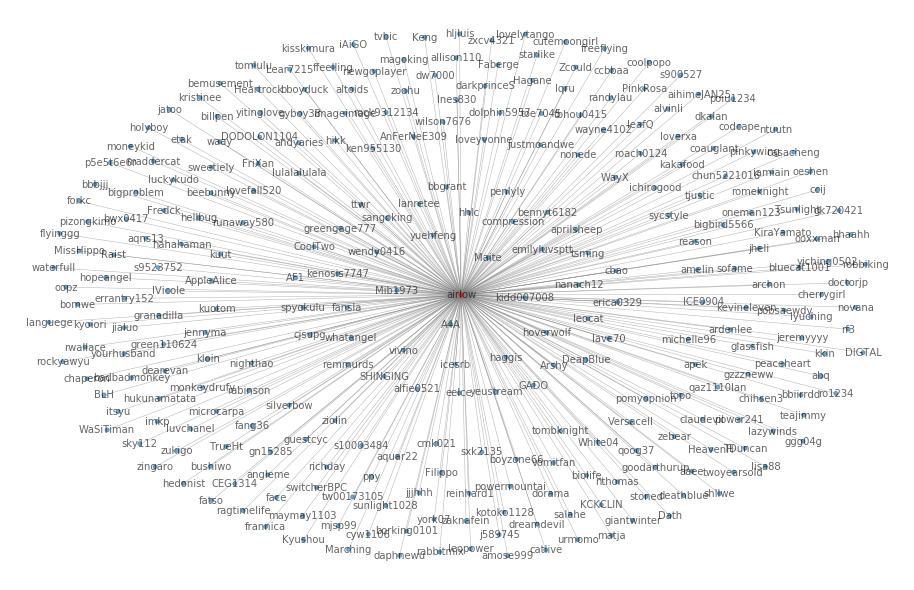

In [36]:
plt.rcParams['figure.figsize'] = [12.5, 8]

# 同溫層網絡
options = {   # see http://bit.ly/2TiIudq for plot options
    'node_size': 15,
    'node_color': ['red' if n.id == 'airlow' else '#1f78b4' for n in G_homo.nodes],
    'edge_color': 'grey', #[attr['weight']/10 for n1,n2,attr in G_homo.edges(data=True)], #'grey',
    'edge_vmin': 1,
    'edge_vmax': 100,
    'font_color': 'k',
    'font_size': 10,
    'width': 0.5,
    'alpha': 0.6,
    'with_labels': True,
    'labels': {n:n.id for n in G_homo.nodes},
}

nx.draw_spring(G_homo,  **options)

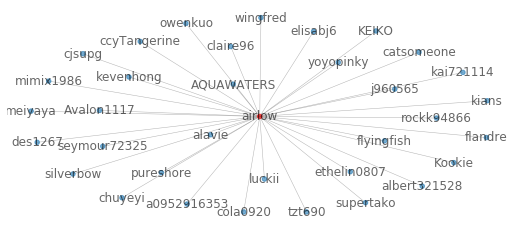

In [37]:
plt.rcParams['figure.figsize'] = [7, 3]

# 異溫層網絡
options = {
    'node_size': 20,
    'node_color': ['red' if n.id == 'airlow' else '#1f78b4' for n in G_hetero.nodes],
    'edge_color': 'grey', #[attr['weight'] for n1,n2,attr in G_hetero.edges(data=True)], #'grey',
    'edge_vmin': 1,
    'edge_vmax': 100,
    'font_color': 'k',
    'font_size': 12,
    'width': 0.5,
    'alpha': 0.6,
    'with_labels': True,
    'labels': {n:n.id for n in G_hetero.nodes},
}

nx.draw_spring(G_hetero,  **options)

### 2.3 例子：以「文章」(主題) 為中心

剛是以「使用者」為起點去找出其他與之相連的使用者，  
但這方式的缺點是看不到**其他使用者之間**的連結。  
透過「文章」為起點則可以解決這個問題。

假設我現在想觀察 [`Re: [求助] 我家男人很沒用`](https://www.pttweb.cc/bbs/Boy-Girl/M.1183446419.A.10E) 這篇以及與此**相關**的文章。  
這時就可以利用 PTT 文章標題的**慣例**找到其它相關的文章：

- `Re: [求助] 我家男人很沒用` (很多篇)
- `[求助] 我家男人很沒用` (理論上？只有一篇)


#### 2.3.1 建立 MultiGraph

要達成這個目標，只要修改 `MultiGraph()` 篩選資料的條件即可：

In [40]:
conditions = {
    'title': {'我家男人很沒用'},
    'tag': {'求助'}
}
MG = MultiGraph(edge_condition=conditions, boards=['Boy-Girl'], years=[2007])

print(f"Num of nodes: {len(MG.nodes)}")
print(f"Num of edges: {len(MG.edges)}")

Num of nodes: 73
Num of edges: 2287


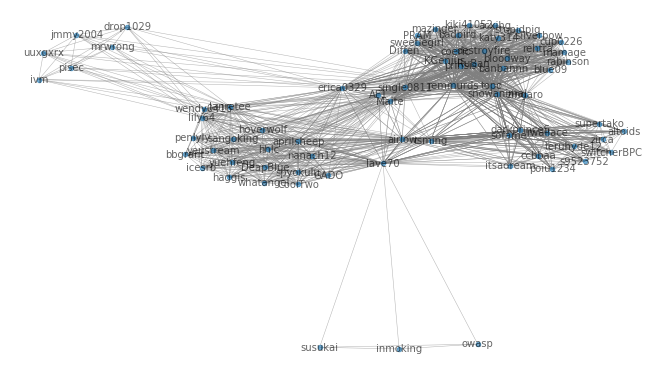

In [45]:
plt.rcParams['figure.figsize'] = [9, 5]

options = {
    'node_size': 20,
    'edge_color': 'grey', #[attr['weight'] for n1,n2,attr in G_hetero.edges(data=True)], #'grey',
    'font_size': 10,
    'width': 0.5,
    'alpha': 0.6,
    'with_labels': True,
    'labels': {n:n.id for n in MG.nodes},
}

nx.draw_spring(MG,  **options)

從上面那張圖，可以猜測大概有 3-5 篇的 `[求助] 我家男人很沒用` (從 cluster 數量猜測)。  
我們可以檢視 `MG.edges` 裡面的資料來確認這點：

In [55]:
edges = [(n1.id, n2.id, data) for n1, n2, data in MG.edges(data=True)]
edges[:2]

[('remmurds',
  'darkprinceS',
  {'title': '我家男人很沒用',
   'isRe': 1,
   'tag': '求助',
   'date': '2007-07-03',
   'board': 'Boy-Girl',
   'opinion': 'pos-pos',
   'text': '20070703_1506_M.1183446419.A.10E.json'}),
 ('remmurds',
  'darkprinceS',
  {'title': '我家男人很沒用',
   'isRe': 1,
   'tag': '求助',
   'date': '2007-07-03',
   'board': 'Boy-Girl',
   'opinion': 'pos-neu',
   'text': '20070703_1506_M.1183446419.A.10E.json'})]

In [59]:
posts = {}
for n1, n2, data in edges:
    id_ = data['text']
    if id_ not in posts:
        posts[id_] = 1
    else:
        posts[id_] += 1

posts

{'20070703_1506_M.1183446419.A.10E.json': 447,
 '20070703_1611_M.1183450271.A.DE9.json': 1376,
 '20070703_1634_M.1183451663.A.2B7.json': 55,
 '20070703_1656_M.1183452979.A.125.json': 403,
 '20070703_1708_M.1183453684.A.6EB.json': 6}

結果確實如預期，總共有五篇文章 (其中 3 篇有許多人互動)

#### 2.3.2 縮減網絡

這邊我們一樣將這個 MultiGraph 縮減成一個**同溫層**、一個**異溫層**網絡看看：

In [47]:
# 同溫層網絡
homo_edge_cond = {
    'opinion': {'pos-pos'}
}
G_homo = Graph(count_edges_in=homo_edge_cond, MG=MG)

# 異溫層網絡
hetero_edge_cond = {
    'opinion': {'pos-neg', 'neg-pos'}
}
G_hetero = Graph(count_edges_in=hetero_edge_cond, MG=MG)



print(f"""
原始
    Num of nodes: {len(MG.nodes)}
    Num of edges: {len(MG.edges)}

同溫層
    Num of nodes: {len(G_homo.nodes)}
    Num of edges: {len(G_homo.edges)}

異溫層
    Num of nodes: {len(G_hetero.nodes)}
    Num of edges: {len(G_hetero.edges)}
""")


原始
    Num of nodes: 73
    Num of edges: 2287

同溫層
    Num of nodes: 60
    Num of edges: 550

異溫層
    Num of nodes: 20
    Num of edges: 19



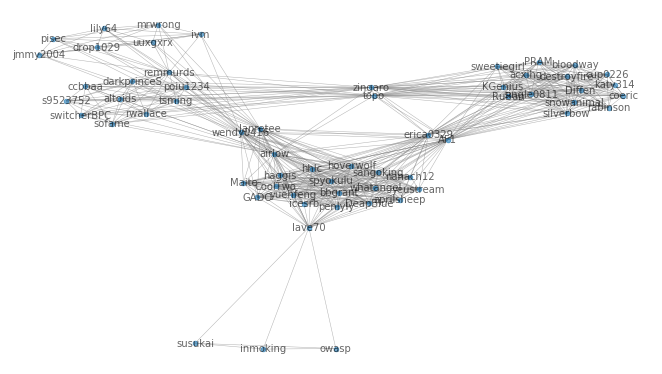

In [48]:
plt.rcParams['figure.figsize'] = [9, 5]

options = {
    'node_size': 20,
    'edge_color': 'grey',
    'font_size': 10,
    'width': 0.5,
    'alpha': 0.6,
    'with_labels': True,
    'labels': {n:n.id for n in G_homo.nodes},
}

nx.draw_spring(G_homo,  **options)

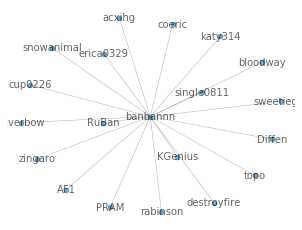

In [63]:
plt.rcParams['figure.figsize'] = [4, 3]

options = {
    'node_size': 20,
    'edge_color': 'grey',
    'font_size': 10,
    'width': 0.5,
    'alpha': 0.6,
    'with_labels': True,
    'labels': {n:n.id for n in G_hetero.nodes},
}

nx.draw_spring(G_hetero,  **options)

## 3. Low-level API: using networkx directly

前面建立的網絡都是**無向**的，但有時候**有向**網絡會是個比較好的工具。  
我目前還未實作無向網絡的 API，因為還**不確定如何利用這種資料結構、這些資料又能回什麼問題？**

這邊我做了一個非常初步的嘗試，利用

In [110]:
# tf-idf to detect important terms
import os
import math
import json

corpus_path = 'data/corpus/segmented/Boy-Girl/2008/'

# Compute TF
posts = {}
for fn in os.listdir(corpus_path):
    with open(os.path.join(corpus_path, fn)) as f:
        data = json.load(f)
        
    terms = {}
    all_terms_count = 0
    for cmt in data['comments']:
        for term in cmt['content'].split('\u3000'):
            all_terms_count += 1
            if term not in terms:
                terms[term] = 1
            else:
                terms[term] += 1
        
    posts[fn] = {t: c/all_terms_count for t, c in terms.items()}


# Compute IDF

D = len(posts)

all_terms = set()
for p, terms in posts.items():
    for t in terms.keys():
        all_terms.add(t)

idf = {}
for t in all_terms:
    idf[t] = math.log10(D / (1 + sum(1 for p, p_terms in posts.items() if t in p_terms) ))
    

# TF-IDF
tf_idf = []
for p, terms in posts.items():
    for term, tf in terms.items():
        #if tf_idf.get(term) is None:
        #    tf_idf[term] = {}
        tf_idf.append((term, p, tf * idf[term]))

# Print sorted
sorted(tf_idf, key=lambda x: x[2], reverse=True)

[('真甜', '20080806_1327_M.1218000447.A.254.json', 1.5242044925621832),
 ('真甜', '20080808_0039_M.1218127148.A.F67.json', 1.1431533694216374),
 ('拍拍', '20080807_1802_M.1218103379.A.5D9.json', 1.0644579892269186),
 ('．', '20080807_1746_M.1218102417.A.393.json', 0.6930257826253389),
 ('剖析', '20080405_1513_M.1207379597.A.52A.json', 0.615599499474739),
 ('pin', '20080807_2309_M.1218121762.A.D29.json', 0.615599499474739),
 ('英國', '20080808_0651_M.1218149499.A.319.json', 0.615599499474739),
 ('LOVE', '20080808_0651_M.1218149499.A.319.json', 0.615599499474739),
 ('687', '20080807_2152_M.1218117172.A.BB8.json', 0.615599499474739),
 ('中肯', '20080406_2037_M.1207485425.A.CD9.json', 0.5647709066085147),
 ('熊熊', '20080807_2309_M.1218121762.A.D29.json', 0.5403420005587437),
 ('看成', '20080807_2309_M.1218121762.A.D29.json', 0.4795824883871701),
 ('50', '20080807_2309_M.1218121762.A.D29.json', 0.46508450164274845),
 ('U', '20080808_0651_M.1218149499.A.319.json', 0.46508450164274845),
 ('', '20080808_0120_

In [2]:
import json
with open("Gossiping.json") as f:
    word_freq = json.load(f)

In [5]:
word_freq['2006']

{'以前': {'Ndda': 59, 'Ng': 215, 'Nddc': 8},
 '聽過': {'NN': 40},
 '某': {'Nes': 209},
 '個': {'DM': 1968, 'Nfa': 1174},
 '研究': {'Nad': 51, 'Nac': 9, 'VE2': 21, 'Nv1': 2},
 '單位': {'Nac': 96},
 '拿回去': {'NN': 3},
 '拆解': {'NN': 1},
 '好像': {'Dbaa': 300, 'VG2': 15, 'P55': 2},
 '是': {'V_11': 7835, 'Dbaa': 773, 'V_12': 11},
 '日本人': {'Nab': 104},
 '吧': {'Tc': 1203},
 '記不': {'NN': 1},
 '清楚': {'VH11': 75, 'VK1': 30},
 '了': {'Ta': 1272, 'Di': 3640, 'Dbab': 29, 'DE': 43, 'Dd': 5, 'VC1': 2},
 '說': {'VE2': 1939},
 '裡面': {'Ncdb': 209},
 '大概': {'Dbaa': 213},
 '有': {'V_2': 3591, 'Nes': 290, 'Dbab': 29, 'P14': 11, 'VC1': 2},
 '的': {'DE': 21246, 'Ta': 259, 'Dbab': 7, 'Di': 4},
 '田七': {'NN': 5},
 '人參': {'NN': 10},
 '種': {'VC33': 787},
 '出產': {'VJ3': 4},
 '於': {'P23': 153},
 '雲南': {'NN': 81},
 '品種': {'Nac': 6},
 '另外': {'Cbcb': 157},
 '還有': {'NN': 475},
 '一': {'Neu': 2666,
  'Dd': 352,
  'Di': 144,
  'DM': 11,
  'Neqa': 2,
  'Caa[P1]': 2,
  'P21': 1},
 '紫雲': {'NN': 6},
 '膏': {'Naa': 7},
 '成分': {'Nac': 15},
 '就是':

In [12]:
input_ = '大葉'
for year in [2005 + i for i in range(15)]:
    year = str(year)
    if word_freq.get(year) is None: continue
    for term in word_freq[year]:
        if term == input_:
            print(f"{year}: {term}, {word_freq[year][term]}")

2005: 大葉, {'NN': 5}
2007: 大葉, {'NN': 1}
2014: 大葉, {'NN': 2}
2015: 大葉, {'NN': 2}
2016: 大葉, {'NN': 41}
2017: 大葉, {'NN': 8}
2018: 大葉, {'NN': 443}
2019: 大葉, {'NN': 4230}


In [16]:
def count(d):
    return sum(v for k, v in d.items())

results = sorted( ((count(count_d), t) for t, count_d in word_freq['2007'].items()), reverse=True)
results

[(38384, '的'),
 (15680, '是'),
 (10367, '我'),
 (9565, '了'),
 (9222, '推'),
 (8135, '有'),
 (7245, '在'),
 (6908, '個'),
 (6885, '這'),
 (6231, '不'),
 (5816, '也'),
 (5729, '一'),
 (5617, '就'),
 (5124, '都'),
 (4795, '你'),
 (4602, '他'),
 (3673, '人'),
 (3670, '很'),
 (3545, '要'),
 (3517, '說'),
 (2862, '跟'),
 (2835, '被'),
 (2760, '會'),
 (2724, '看'),
 (2664, '那'),
 (2587, '好'),
 (2573, '吧'),
 (2439, '八卦'),
 (2385, '嗎'),
 (2328, '可以'),
 (2272, '上'),
 (2240, '啊'),
 (2172, '還'),
 (2149, '就是'),
 (1930, '台灣'),
 (1926, '沒'),
 (1877, '真的'),
 (1789, '因為'),
 (1676, '又'),
 (1669, '他們'),
 (1664, '知道'),
 (1630, '大'),
 (1626, '沒有'),
 (1616, '去'),
 (1599, '她'),
 (1580, '種'),
 (1541, '和'),
 (1513, '篇'),
 (1506, '我們'),
 (1480, '讓'),
 (1467, '想'),
 (1465, '把'),
 (1463, '朝聖'),
 (1446, '自己'),
 (1414, '所以'),
 (1369, '啦'),
 (1362, '什麼'),
 (1348, '但'),
 (1317, '還是'),
 (1316, '來'),
 (1303, '對'),
 (1296, '才'),
 (1265, '阿'),
 (1255, '與'),
 (1235, '不過'),
 (1212, '到'),
 (1202, '次'),
 (1196, '這樣'),
 (1174, '加油'),
 (1136, '但是')

In [9]:
[2005 + i for i in range(14)]

[2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018]